In [7]:
# Import libraries 
from tqdm import tqdm

import numpy as np
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor

import matplotlib.pyplot as plt

#### 1. Prepare functions for model setup and training

In [8]:
# Define a simple two layer network
class LLayerNN(nn.Module):
    """ 
    Implementation of a general L-layer fully connected neural network.
    """
    
    def __init__(self, network_params):
        super().__init__()

        self.activations = nn.ModuleDict([
            ['sigmoid', nn.Sigmoid()],
            ['tanh', nn.Tanh()],
            ['relu', nn.ReLU()],
        ])

        blocks = []
        for L_param in network_params[:-1]:
            blocks.append(self._linear_block(
                in_features=L_param[0], 
                out_features=L_param[1], 
                activation=L_param[2],
                dropout_prob=L_param[3],
            ))
        self.block = nn.Sequential(*blocks)
        
        self.linear = nn.Linear(
            in_features=network_params[-1][0], 
            out_features=network_params[-1][1]
        )
        self.softmax = nn.Softmax(dim=1)

    def _linear_block(self, in_features, out_features, activation="relu", dropout_prob=0.0):
        
        return nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.Dropout(p=dropout_prob),
            self.activations[activation],
        )
        
    def forward(self, x):
        x = self.block(x)
        x = self.linear(x)
        output = self.softmax(x)
        return output

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """ Perform a training loop."""
    running_loss = 0
    
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        
        # Send the batch samples to a device
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        # Update model weights
        optimizer.step()
        # Re-set gradients to zero for next batch
        optimizer.zero_grad()

    avg_training_loss = running_loss / len(dataloader)
    
    return avg_training_loss

In [10]:
def validation_loop(dataloader, model, loss_fn):
    """ Perform a validation loop."""
    running_loss = 0
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:

            # Send the batch samples to a device
            X, y = X.to(device), y.to(device)
            
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss.item()

    avg_validation_loss = running_loss / len(dataloader)

    return avg_validation_loss

In [11]:
def train_model(training_generator, validation_generator, model, loss_fn, optimizer, epochs):
    
    # Collect results
    training_loss = []
    validation_loss = []
    
    for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

        # Perform a training step
        running_training_loss = train_loop(
            dataloader=training_generator, 
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer
        )
        training_loss.append(running_training_loss)

        # Perform a validation step
        running_validation_loss = validation_loop(
            dataloader=validation_generator,
            model=model,
            loss_fn=loss_fn
        )
        validation_loss.append(running_validation_loss)

    return training_loss, validation_loss

In [12]:
def plot_loss(training_loss, validation_loss, model_id):
    """ Plot training and validation losses."""
    fig = plt.figure(figsize=[5, 3])
    ax = fig.add_subplot(111)
    ax.plot(training_loss, label="Training loss")
    ax.plot(validation_loss, label="Validation loss")
    ax.set_title("Model: {}".format(model_id))
    ax.legend()

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
# Define training tools
loss_functions = {
    "binary_cross_entropy": nn.BCELoss,
    "cross_entropy": nn.CrossEntropyLoss
}
optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam,
}
# Search for a device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "cpu"
)

#### 2. Configuration

In [25]:
# Define parameters configuration
# https://github.com/victoresque/pytorch-template/blob/master/README.md
params = {
    "data_splitting" : {
        # "train_ratio": 0.8,
        "validation_ratio": 0.1,
        # "test_ratio": 0.1,
    },
    
    "dataloader": {
        "batch_size": 128,
        "shuffle": True,
        "num_workers" : 0
    },
    
    "loss": {
        "type": "cross_entropy",
        "params" : {
            "reduction": "mean"
        }
    },

    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001,
            "betas": (0.9, 0.999), 
            "eps": 1e-08,
            # "weight_decay": 0.001,
            # "momentum": 0,
            # "weight_decay": 0.001,
        }
    },

    "training": {
        "epochs" : 20
    },
}  

#### 3. Prepare training, validation, and test sets

In [16]:
# Load the training data
mnist_train = datasets.MNIST(
    root="datasets",
    train=True,
    download=True,
    transform=Compose([
        ToTensor(),
        torch.flatten,
    ]))

# Load the test data
mnist_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=Compose([
        ToTensor(),
        torch.flatten,
    ]))

In [17]:
# Generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=0.1,
)

In [18]:
# Generate a subset based on indices
training_dataset = Subset(mnist_train, train_indices)
validation_dataset = Subset(mnist_train, val_indices)

In [19]:
# Create generators
training_generator = DataLoader(training_dataset, **params["dataloader"])
validation_generator = DataLoader(validation_dataset, **params["dataloader"])
test_generator = DataLoader(mnist_test, **params["dataloader"])

#### 4. Initialize the model

In [20]:
# Instantiate a model
network_params = [
    # [in_f, out_f, activation, dropout_prob]
    [28 * 28, 256, "relu", 0.0],
    [256, 256, "relu", 0.0],
    [256, 10, "none", "none"],
]
model = LLayerNN(network_params=network_params)
# Transfer the model to device
model.to(device)

# Number of epochs
epochs = params["training"]["epochs"]
# Define a binary cross entropy loss
loss_fn = loss_functions[params["loss"]["type"]](**params["loss"]["params"])
# Define a stochastic gradient descent as an optimizer
optimizer = optimizers[params["optimizer"]["type"]](model.parameters(), **params["optimizer"]["params"])

#### 5. Train the model and check performance

In [21]:
# Train and evaluate the model
training_loss, validation_loss = train_model(
    training_generator=training_generator, 
    validation_generator=validation_generator, 
    model=model, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    epochs=epochs
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


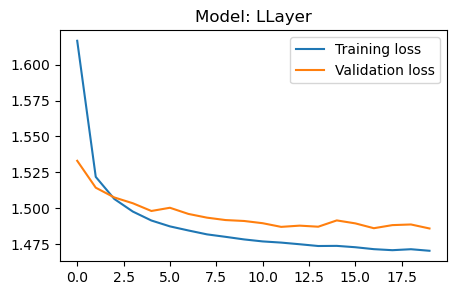

In [22]:
plot_loss(training_loss, validation_loss, "LLayer")

In [24]:
test(model=model, device=device, test_loader=test_generator)


Test set: Average loss: 1.4828, Accuracy: 9783/10000 (98%)

